## RANKING NATIONS BASED ON SPORTS

* Across the world over 250 nations  participate in a sport which happens throughout the year. An advertising company is intereted in selecting few players from the current top ranking teams for advertising a new launch. A special team was set up by the company, which collected data for a lot of years.

The data set contains the following features:
* Rank
* Country
* Country Abbreviation
* Total Points
* Previous Points
* Rank Change
* Curr_year avg

Based on the above data, generate a model with high accuracy which helps to predict the ranks of the teams in 2018. Which are the most consistent teams in 2018? Which are the teams who will improve the most? 

In [44]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.vector_ar.var_model import VAR
import statsmodels.api
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('sports_data.csv')
#removing countries with fewer than 77 entries
countries = df["country_abrv"].unique()
waste=[]

for i in countries:
    if len(df.loc[df["country_abrv"] == i])!=77:
        waste+=[i]
drop_list=[]

for i in waste:
    drop_list+=df.index[df["country_abrv"]==i].tolist()
df = df.drop(df.index[drop_list])

#removing duplicate rows
df=df.drop_duplicates(subset=["country_abrv","rank_date"],keep='first')


In [3]:
# Make the date as the index and convert to datetime object
df.index = df['rank_date']
del df['rank_date']
df.index  = pd.to_datetime(df.index)
len(df)

15785

In [4]:
# groupby timestep
df_by_tstep = df.groupby(df.index)

In [5]:
# Creating the train and validation set. f is the fraction of data to be used in training set.
def split_data(X,y,f):
    x_train = X[:int(f*(len(X)))]
    x_val = X[int(f*(len(X))):]
    y_train = y[:int(f*len(y))]
    y_val = y[int(f*len(y)):]
    return x_train,y_train,x_val,y_val

In [6]:
# Train ARIMA model
def train(x_train,y_train): 
    model = statsmodels.api.tsa.statespace.SARIMAX(endog=y_train,exog=x_train).fit()
    pred = model.predict(dynamic=True,exog=x_train)
    return model,pred

In [7]:
# Predict the y values for the validation set
def forecast(model,x_val,y_val):
    return model.forecast(steps=len(y_val),exog=x_val)

In [8]:
# Plotting predictions
def plot_it(x_train,y_train,x_val,y_val):
    plt.plot(y_train,label="Train true values")
    plt.plot(pred,label="Train pred values")
    plt.plot(y_val,label="Validation true values")
    plt.plot(y_pred_val,label="Validation pred values")
    plt.legend()
    plt.show()

In [9]:
# Groupby country and select the first one (Afghanistan)
grouped = df.groupby(df['country_abrv'])
abbrvs = list(grouped.groups.keys())
k = abbrvs[0]

df_per_ctry = grouped.get_group(k)
df_per_ctry.dropna(inplace=True)

# Add new features
df_per_ctry['last_yr_avg'] = df_per_ctry['cur_year_avg']
df_per_ctry['last_yr_avg'].values[1:-1] = df_per_ctry['cur_year_avg'].values[0:-2]

df_per_ctry['last_2yr_avg'] = df_per_ctry['last_yr_avg']
df_per_ctry['last_2yr_avg'].values[1:-1] = df_per_ctry['last_yr_avg'].values[0:-2]

df_per_ctry['last_3yr_avg'] = df_per_ctry['last_2yr_avg']
df_per_ctry['last_3yr_avg'].values[1:-1] = df_per_ctry['last_2yr_avg'].values[0:-2]

df_per_ctry['rank_change_2yr'] = df_per_ctry['rank_change']
df_per_ctry['rank_change_2yr'].values[1:-1] = df_per_ctry['rank_change'].values[0:-2]

df_per_ctry['prev_2yr_points'] = df_per_ctry['previous_points']
df_per_ctry['prev_2yr_points'].values[1:-1] = df_per_ctry['previous_points'].values[0:-2]

df_per_ctry['prev_3yr_points'] = df_per_ctry['prev_2yr_points']
df_per_ctry['prev_3yr_points'].values[1:-1] = df_per_ctry['prev_2yr_points'].values[0:-2]

df_per_ctry.dropna(inplace=True)
#df_per_ctry.head()
len(df_per_ctry)

77

In [11]:
scaler = MinMaxScaler()
df_per_ctry['cur_year_avg'] = scaler.fit_transform(df_per_ctry['cur_year_avg'].values.reshape(-1,1))
df_per_ctry['last_yr_avg'] = scaler.fit_transform(df_per_ctry['last_yr_avg'].values.reshape(-1,1))
df_per_ctry['last_2yr_avg']=scaler.fit_transform(df_per_ctry['last_2yr_avg'].values.reshape(-1,1))
df_per_ctry['last_3yr_avg']=scaler.fit_transform(df_per_ctry['last_3yr_avg'].values.reshape(-1,1))
df_per_ctry['total_points']=scaler.fit_transform(df_per_ctry['total_points'].values.reshape(-1,1))

In [12]:
# Initialize for kmeans
num_clust = 50
kmeans = KMeans(n_clusters=num_clust)

In [13]:
# We want to make a new dataframe with columns as timesteps and row as total points for each country
df_unwrapped_time = pd.DataFrame(columns = ['country_abrv'])
df_unwrapped_time['country_abrv'] = abbrvs
df_unwrapped_time.index =  df_unwrapped_time['country_abrv']
del df_unwrapped_time['country_abrv']

In [14]:
# Remove countries with fewer/too much data
for abv in df_unwrapped_time.index:
    if len(grouped.get_group(abv)) != 77:
          df_unwrapped_time.drop(abv,axis=0,inplace=True)

In [15]:
# contains unique timesteps
dats = set(df.index)

In [16]:
# add new column for each timestep
for i,dat in enumerate(dats):
    df_unwrapped_time.insert(i,dat,0)

In [17]:
# fill the dataframe with total_points entries
for i,abrv in enumerate(df_unwrapped_time.index):
    df_for_ctry = grouped.get_group(abrv)
    arr = np.array(df_for_ctry['total_points'])
    df_unwrapped_time.iloc[i] = arr

In [18]:
kmeans.fit(df_unwrapped_time)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=50, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [19]:
# Add new column for kmeans labels (groups)
df_unwrapped_time['Label'] = list(kmeans.labels_)

In [20]:
df_unwrapped_time.head()

,2015-02-12 00:00:00,2017-01-12 00:00:00,2013-05-09 00:00:00,2014-08-14 00:00:00,2016-10-20 00:00:00,2013-04-11 00:00:00,2011-12-21 00:00:00,2012-02-15 00:00:00,2015-12-03 00:00:00,2014-04-10 00:00:00,...,2012-11-07 00:00:00,2011-09-21 00:00:00,2016-12-22 00:00:00,2012-07-04 00:00:00,2016-06-02 00:00:00,2012-05-09 00:00:00,2017-06-01 00:00:00,2014-07-17 00:00:00,2016-05-05 00:00:00,Label
country_abrv,,,,,,,,,,,,,,,,,,,,,
AFG,70.28,70.28,68.58,77.41,85.32,85.32,85.32,85.32,118.39,114.81,...,161.21,161.29,140.09,160.12,160.12,146.79,168.13,181.11,181.11,29
AIA,7.33,8.80,8.80,8.80,8.80,8.80,8.80,8.80,8.80,8.80,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,32
ALB,546.27,473.76,461.96,449.94,449.94,449.94,451.89,432.16,383.81,383.81,...,532.91,532.91,544.04,582.62,582.62,551.23,498.02,552.62,552.62,17
ALG,612.36,604.70,713.36,757.94,757.94,734.50,683.52,709.54,666.59,666.59,...,627.88,627.88,636.04,676.52,676.52,563.85,539.54,536.76,588.29,39
AND,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,65.56,65.56,68.82,246.42,246.42,191.46,191.46,214.80,214.80,32


In [21]:
gp = df_unwrapped_time.groupby('Label')

In [22]:
# Get label for Afghanistan
x = df_unwrapped_time.loc[[k],['Label']].values[0][0]
x

29

In [23]:
# Get the group for AFG
df_x = gp.get_group(x)

In [24]:
# Make a list of the other countries in the cluster
surr_country_abvs = []
for abv in df_x.index:
    if abv != k:
        surr_country_abvs.append(abv)
surr_country_abvs

['ARU', 'BRB', 'HKG', 'IND', 'LCA', 'LES', 'MAS', 'MDV', 'MYA', 'SIN']

In [25]:
# For each time step, add the new features (points,rank change, curr_year_avg) of the surrounding countries
df_extra_feat = pd.DataFrame([])
for tstep in df_per_ctry.index.values:
    extra_feat = []
    ex_feats = []
    df_per_tstep = df_by_tstep.get_group(tstep)
    df_abrv_index = df_per_tstep.set_index('country_abrv')
    for abv in surr_country_abvs:
        extra_feat.append(df_abrv_index.loc[abv][3:].values.reshape(-1))
    numcountries = feat0 = feat1 = feat2 = 0.0
    for i,arr in enumerate(extra_feat):
        feat0 += arr[0]
        feat1 += arr[1]
        feat2 += arr[2]
        numcountries += 1
        #ex_feats.append(arr[0])
        #ex_feats.append(arr[1])
        #ex_feats.append(arr[2])
    ex_feats = np.array([feat0/numcountries,feat1/numcountries,feat2/numcountries])
    #print(ex_feats)
    df_extra_feat = df_extra_feat.append(pd.Series(ex_feats),ignore_index=True)

In [26]:
df_extra_feat.head()

,0,1,2
0,119.0,-1.5,58.906
1,115.6,0.2,62.016
2,117.8,0.2,58.407
3,124.6,-3.8,63.784
4,116.1,0.7,70.419


In [28]:
# Add new features to original dataframe
df_extra_feat.index = df_per_ctry.index
df_per_ctry = pd.concat([df_per_ctry,df_extra_feat],axis=1)
df_per_ctry1 = df_per_ctry.copy()
df_per_ctry

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,last_yr_avg,last_2yr_avg,last_3yr_avg,rank_change_2yr,prev_2yr_points,prev_3yr_points,0,1,2,0,1,2
rank_date,,,,,,,,,,,,,,,,,,,
2011-08-24,181,Afghanistan,AFG,0.164929,73,-2,0.377028,0.377028,0.377028,0.377028,-2,73,73,119.0,-1.5,58.906,119.0,-1.5,58.906
2011-09-21,183,Afghanistan,AFG,0.164929,70,-2,0.377028,0.377028,0.377028,0.377028,-2,73,73,115.6,0.2,62.016,115.6,0.2,62.016
2011-10-19,184,Afghanistan,AFG,0.155888,70,-1,0.377028,0.377028,0.377028,0.377028,-2,70,73,117.8,0.2,58.407,117.8,0.2,58.407
2011-11-23,178,Afghanistan,AFG,0.202851,69,6,0.430889,0.377028,0.377028,0.377028,-1,70,70,124.6,-3.8,63.784,124.6,-3.8,63.784
2011-12-21,177,Afghanistan,AFG,0.244921,77,1,0.479139,0.430889,0.377028,0.377028,6,69,70,116.1,0.7,70.419,116.1,0.7,70.419
2012-01-18,177,Afghanistan,AFG,0.244921,85,0,0.479139,0.479139,0.430889,0.377028,1,77,69,121.6,-0.3,69.379,121.6,-0.3,69.379
2012-02-15,178,Afghanistan,AFG,0.244921,85,-1,0.479139,0.479139,0.479139,0.430889,0,85,77,121.0,-1.2,68.733,121.0,-1.2,68.733
2012-03-07,178,Afghanistan,AFG,0.244921,85,0,0.479139,0.479139,0.479139,0.479139,-1,85,85,119.5,-0.3,67.511,119.5,-0.3,67.511
2012-04-11,168,Afghanistan,AFG,0.420806,85,10,0.484141,0.479139,0.479139,0.479139,0,85,85,116.5,-1.8,67.148,116.5,-1.8,67.148


In [29]:
df_per_ctry1

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,last_yr_avg,last_2yr_avg,last_3yr_avg,rank_change_2yr,prev_2yr_points,prev_3yr_points,0,1,2,0,1,2
rank_date,,,,,,,,,,,,,,,,,,,
2011-08-24,181,Afghanistan,AFG,0.164929,73,-2,0.377028,0.377028,0.377028,0.377028,-2,73,73,119.0,-1.5,58.906,119.0,-1.5,58.906
2011-09-21,183,Afghanistan,AFG,0.164929,70,-2,0.377028,0.377028,0.377028,0.377028,-2,73,73,115.6,0.2,62.016,115.6,0.2,62.016
2011-10-19,184,Afghanistan,AFG,0.155888,70,-1,0.377028,0.377028,0.377028,0.377028,-2,70,73,117.8,0.2,58.407,117.8,0.2,58.407
2011-11-23,178,Afghanistan,AFG,0.202851,69,6,0.430889,0.377028,0.377028,0.377028,-1,70,70,124.6,-3.8,63.784,124.6,-3.8,63.784
2011-12-21,177,Afghanistan,AFG,0.244921,77,1,0.479139,0.430889,0.377028,0.377028,6,69,70,116.1,0.7,70.419,116.1,0.7,70.419
2012-01-18,177,Afghanistan,AFG,0.244921,85,0,0.479139,0.479139,0.430889,0.377028,1,77,69,121.6,-0.3,69.379,121.6,-0.3,69.379
2012-02-15,178,Afghanistan,AFG,0.244921,85,-1,0.479139,0.479139,0.479139,0.430889,0,85,77,121.0,-1.2,68.733,121.0,-1.2,68.733
2012-03-07,178,Afghanistan,AFG,0.244921,85,0,0.479139,0.479139,0.479139,0.479139,-1,85,85,119.5,-0.3,67.511,119.5,-0.3,67.511
2012-04-11,168,Afghanistan,AFG,0.420806,85,10,0.484141,0.479139,0.479139,0.479139,0,85,85,116.5,-1.8,67.148,116.5,-1.8,67.148


In [30]:
df_per_ctry.dropna(inplace=True)
#shuffle the data
df_per_ctry = df_per_ctry.sample(frac=1).reset_index(drop=True)

In [31]:
# Make dataset
y = df_per_ctry['total_points'].values
df_per_ctry.drop(df_per_ctry.columns[0:4],axis=1,inplace=True)
df_per_ctry1.drop(df_per_ctry1.columns[0:4],axis=1,inplace=True)
X = df_per_ctry.values
X1 = df_per_ctry1.values
X

array([[  1.90000000e+02,   2.00000000e+00,   9.18018787e-01, ...,
          1.50300000e+02,   1.00000000e-01,   1.03198000e+02],
       [  1.79000000e+02,   0.00000000e+00,   4.56264487e-01, ...,
          1.68900000e+02,  -2.00000000e-01,   7.04810000e+01],
       [  1.84000000e+02,   2.00000000e+00,   9.76332805e-01, ...,
          1.46900000e+02,   4.00000000e-01,   7.81630000e+01],
       ..., 
       [  1.21000000e+02,  -1.90000000e+01,   0.00000000e+00, ...,
          1.38900000e+02,   3.00000000e+00,   8.00840000e+01],
       [  1.79000000e+02,  -5.00000000e+00,   4.56264487e-01, ...,
          1.71000000e+02,  -6.00000000e-01,   7.04810000e+01],
       [  1.18000000e+02,  -2.00000000e+00,   4.84140539e-01, ...,
          1.18700000e+02,   2.00000000e-01,   6.76550000e+01]])

In [32]:
print(np.corrcoef(np.transpose(X)))

[[  1.00000000e+00  -2.87524374e-01   4.96567113e-01   6.79079581e-01
    5.54125077e-01   4.68448339e-01   1.97754874e-01   8.76649803e-01
    7.81774735e-01   6.56783235e-01   4.07267183e-02   4.05746017e-01
    6.56783235e-01   4.07267183e-02   4.05746017e-01]
 [ -2.87524374e-01   1.00000000e+00   3.38865038e-01  -2.39418983e-01
   -1.73762412e-01  -2.19964377e-01  -9.55153121e-02  -2.33906194e-01
   -2.30217217e-01  -8.18164059e-02   6.06214537e-04   5.50140930e-02
   -8.18164059e-02   6.06214537e-04   5.50140930e-02]
 [  4.96567113e-01   3.38865038e-01   1.00000000e+00   7.42141862e-01
    5.57413679e-01   3.62538301e-01   2.74617637e-01   3.62350879e-01
    2.39924519e-01   9.74520575e-02   9.21676192e-02   2.98192826e-01
    9.74520575e-02   9.21676192e-02   2.98192826e-01]
 [  6.79079581e-01  -2.39418983e-01   7.42141862e-01   1.00000000e+00
    7.46313749e-01   5.66324929e-01   3.41505359e-01   5.03838087e-01
    3.73249184e-01   1.29927258e-01   3.68104628e-02   1.57139076e-0

In [34]:
y

array([ 0.90554196,  0.74534624,  0.76773747,  0.24492075,  0.53621955,
        0.76523774,  0.86996064,  0.79725561,  0.79725561,  0.64275077,
        0.90554196,  0.44117647,  0.76523774,  0.64854803,  0.44117647,
        0.64275077,  0.90554196,  0.91357302,  0.74375066,  0.24492075,
        0.92862461,  0.91942347,  0.93803851,  0.8952771 ,  0.76773747,
        0.94591001,  0.80044676,  0.64897351,  0.82289118,  0.87432188,
        0.85900436,  0.88916073,  0.92851824,  0.76773747,  0.94591001,
        0.88916073,  0.75316456,  0.89644719,  0.43213488,  0.68535262,
        0.80347835,  0.7672588 ,  0.20285076,  0.91942347,  0.        ,
        0.9943623 ,  0.9793639 ,  0.44117647,  0.4208063 ,  0.80347835,
        0.93245399,  0.92862461,  0.24492075,  0.87256675,  0.92655037,
        0.99340496,  0.15588767,  0.52425274,  0.        ,  1.        ,
        0.16492926,  0.44117647,  0.76475907,  0.92851824,  0.68221466,
        0.80964791,  0.90873311,  0.99095841,  0.24492075,  0.16

In [35]:
# split data and train
x_train,y_train,x_val,y_val = split_data(X,y,0.8)
model,train_pred = train(x_train=x_train,y_train=y_train)
train_pred = scaler.inverse_transform(train_pred.reshape(-1,1))
y_train = scaler.inverse_transform(y_train.reshape(-1,1))

In [36]:
len(x_train)

61

In [37]:
print("Training MSE LOSS : {}".format(mean_squared_error(y_train,train_pred)))

Training MSE LOSS : 0.0010216947514658024


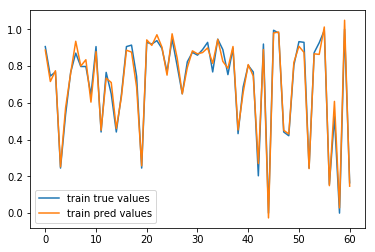

In [38]:
# Training curves
plt.plot(y_train,label="train true values")
plt.plot(train_pred,label="train pred values")
plt.legend()
plt.show()

In [39]:
val_pred = forecast(model=model,x_val=x_val,y_val=y_val)
val_pred = scaler.inverse_transform(val_pred.reshape(-1,1))
y_val = scaler.inverse_transform(y_val.reshape(-1,1))
print("Test MSE LOSS : {}".format(mean_squared_error(y_val,val_pred)))

Test MSE LOSS : 0.0025307931278214886


In [40]:
X1.shape

(77, 15)

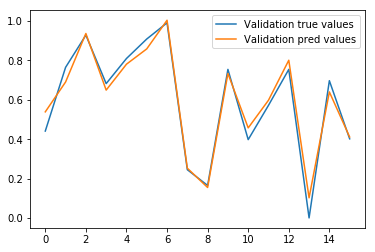

In [41]:
# Validation curves
plt.plot(y_val,label="Validation true values")
plt.plot(val_pred,label="Validation pred values")
plt.legend()
plt.show()

In [ ]:
x_train_new1 = (X1[-12]+X1[-11]+X1[-10]+X1[-9]+X1[-8]+X1[-7]+X1[-6]+X1[-5]+X1[-4]+X1[-3]+X1[-2]+X1[-1])/12 + np.random.normal(0,1,12)
x_train_new2 = (X1[-11]+X1[-10]+X1[-9]+X1[-8]+X1[-7]+X1[-6]+X1[-5]+X1[-4]+X1[-3]+X1[-2]+X1[-1]+x_train_new1)/12 + np.random.normal(0,1,12)
x_train_new3 = (X1[-10]+X1[-9]+X1[-8]+X1[-7]+X1[-6]+X1[-5]+X1[-4]+X1[-3]+X1[-2]+X1[-1]+x_train_new1+x_train_new2)/12 + np.random.normal(0,1,12)
x_train_new4 = (X1[-9]+X1[-8]+X1[-7]+X1[-6]+X1[-5]+X1[-4]+X1[-3]+X1[-2]+X1[-1]+x_train_new1+x_train_new2+x_train_new3)/12 + np.random.normal(0,1,12)
x_train_new5 = (X1[-8]+X1[-7]+X1[-6]+X1[-5]+X1[-4]+X1[-3]+X1[-2]+X1[-1]+x_train_new1+x_train_new2+x_train_new3+x_train_new4)/12 + np.random.normal(0,1,12)
x_train_new6 = (X1[-7]+X1[-6]+X1[-5]+X1[-4]+X1[-3]+X1[-2]+X1[-1]+x_train_new1+x_train_new2+x_train_new3+x_train_new4+x_train_new5)/12 + np.random.normal(0,1,12)

In [43]:
np.mean(X1,axis=-1)
np.std(X1,axis=-1)

array([ 40.14665003,  39.83954821,  40.34946512,  41.25600064,
        40.94383269,  43.20791202,  44.44757591,  44.7239398 ,
        44.21503118,  48.38325525,  51.70250824,  53.36635882,
        53.7427311 ,  54.64952595,  55.78087379,  57.09318992,
        61.00703313,  57.12087247,  50.57642194,  43.93428504,
        63.39852224,  80.20964535,  90.17453275,  92.46718367,
        93.3168645 ,  92.79704405,  94.34659494,  95.09285636,
        96.9436457 ,  92.52079732,  87.06160166,  80.70924731,
        82.51337079,  89.4947842 ,  92.28017515,  94.08359432,
        92.01277569,  95.03361538,  95.89565325,  94.53426555,
        95.02001934,  93.13361755,  89.84500155,  85.27390955,
        86.60845125,  88.23846033,  92.47306805,  83.56558262,
        85.01662162,  86.28242971,  96.5023005 ,  94.46407489,
        89.12506148,  85.61312074,  86.52598887,  88.19867439,
        87.59643209,  90.51734908,  94.73142779,  92.2421321 ,
        88.77909937,  88.31297901,  89.84222217,  90.04

In [44]:
array1 = []
array1.append (x_train_new1)
array1.append (x_train_new2)
array1.append (x_train_new3)
array1.append (x_train_new4)

In [46]:
val1=model.forecast(steps=4,exog=array1)
val1 = scaler.inverse_transform(val1.reshape(-1,1))

In [49]:
y_val_new=np.append(y_val,val1)

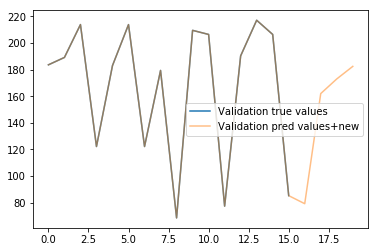

In [51]:
plt.plot(y_val,label="Validation true values")
plt.plot(y_val_new,label="Validation pred values+new",alpha=0.5)
plt.legend()
plt.show()